# Advanced Tutorial

### Modifying the BaseAgent
To demonstrate the direct method, let's build a new ``human`` agent from scratch. We'll start with the simples version: a human that consumes oxygen every step. In order to build this using the Direct method, we will:

1. Initialize an empty AgentModel
2. Add a currency, ``o2``
3. Create a ``habitat`` agent which has capacity for 1000 o2, and has 1000 o2 in storage
4. Create a ``human`` agent which has an in-flow of 1 o2 per step from the habitat
5. Add these agents to the model
6. Run the model for 100 steps
7. Plot the habitat storage and human flows

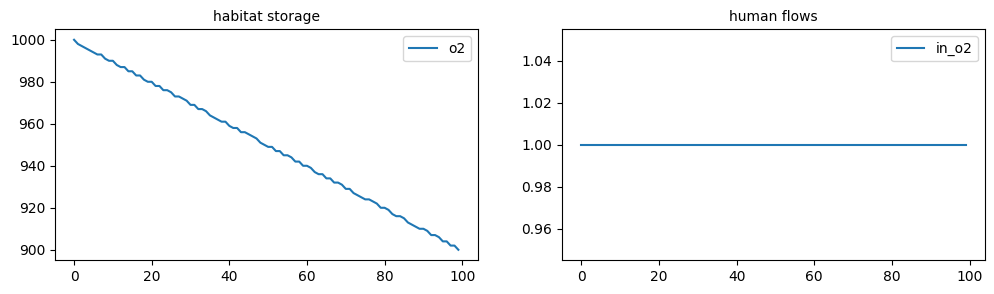

In [1]:
# Ignore this
import sys
sys.path.append('../..')

from simoc_abm import AgentModel, BaseAgent, plot_agent
import matplotlib.pyplot as plt

# Helper function to run model and plot records
def run_and_plot(model):
    for i in range(100):
        model.step()
    records = model.get_records()
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    plot_agent(records, 'habitat', 'storage', ax=axs[0]);
    plot_agent(records, 'human', 'flows', ax=axs[1]);
    return records

# Initialize Model with 'o2' currency
model = AgentModel()
model.add_currency('o2')

# Initialize Agents
habitat = BaseAgent(model, 'habitat', capacity={'o2': 1000}, storage={'o2': 1000})
human = BaseAgent(model, 'human', flows={'in': {'o2': {'value': 1, 'connections': ['habitat']}}})

# Add agents to the model
model.add_agent('habitat', habitat)
model.add_agent('human', human)

records = run_and_plot(model)

The habitat storage line is uneven. This is because, without a ``priorities`` argument and defined classes, agents step in a random order. Records are saved at the end of each agent's step, so if the habitat steps before the human on some step, the human's flow won't be taken into account. We can fix this by adding a class to each agent, and adding a 'priorities' argument to our AgentModel.

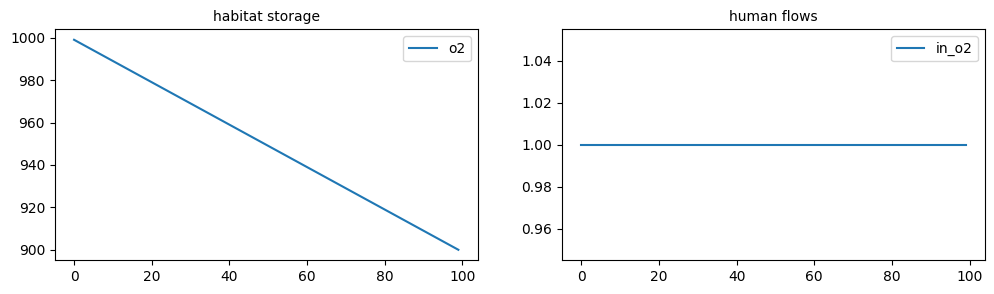

In [2]:
model = AgentModel(priorities=['inhabitants', 'structures'])
model.add_currency('o2')
habitat = BaseAgent(model, 
                    'habitat', 
                    agent_class='structures', 
                    capacity={'o2': 1000}, 
                    storage={'o2': 1000})
human = BaseAgent(model, 
                  'human', 
                  agent_class='inhabitants', 
                  flows={'in': {'o2': {'value': 1, 'connections': ['habitat']}}})
model.add_agent('habitat', habitat)
model.add_agent('human', human)
records = run_and_plot(model)

Of course humans also exhale carbon dioxide, and it should be proportional to the oxygen they inhale. Let's add this with a new currency, ``co2``. We'll need to:
1. Add another currency
2. Add capacity for that currency in our habitat
3. Add an out-flow of co2 to our human
4. Make this outflow proportional to the inflow of co2 using the 'requires' field.

To make sure we've done (4.) correctly, let's initialize our habitat with less than enough o2.

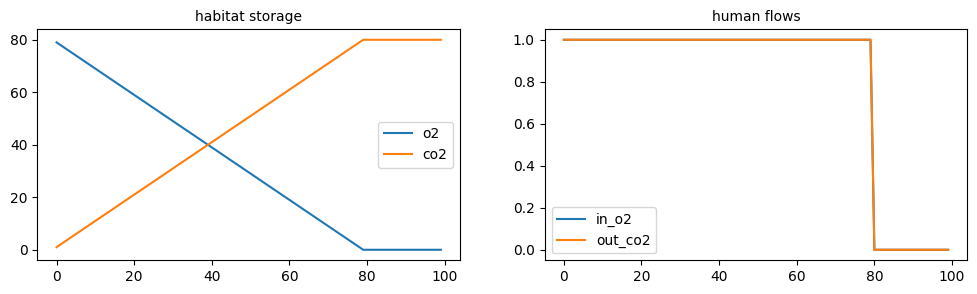

In [3]:
model = AgentModel(priorities=['inhabitants', 'structures'])
model.add_currency('o2')
model.add_currency('co2')
habitat = BaseAgent(model, 
                    'habitat', 
                    agent_class='structures', 
                    capacity={'o2': 1000, 'co2': 1000}, 
                    storage={'o2': 80})
human = BaseAgent(model, 
                  'human', 
                  agent_class='inhabitants', 
                  flows={'in': {'o2': {'value': 1, 
                                       'connections': ['habitat']}},
                         'out': {'co2': {'value': 1,
                                         'connections': ['habitat'],
                                         'requires': ['o2']}}})
model.add_agent('habitat', habitat)
model.add_agent('human', human)
records = run_and_plot(model)

Humans die if they don't get enough oxygen. This usually happens after a couple minutes, but for demonstration purposes let's say this happens after 5 steps (hours):

1. Add a ``deprive`` parameter to the o2 flow such that the agent will die if it doesn't get the target amount for 5 consecutive steps.
2. Deprive uses an ``attribute`` to track the time left, so let's create a new helper function to also plot the human attributes.

human deprived of o2


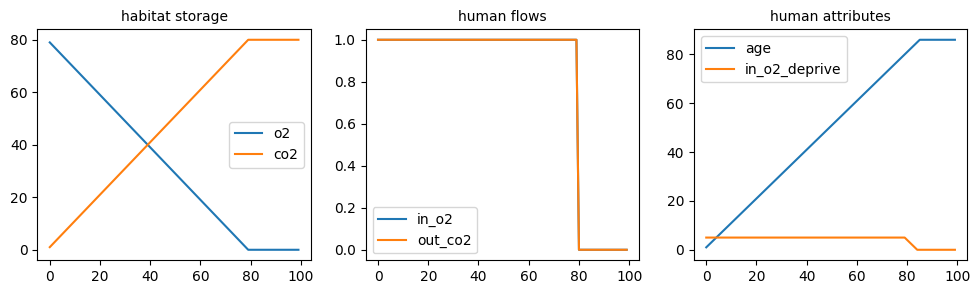

In [4]:
def run_and_plot(model):
    for i in range(100):
        model.step()
    records = model.get_records()
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    plot_agent(records, 'habitat', 'storage', ax=axs[0]);
    plot_agent(records, 'human', 'flows', ax=axs[1]);
    plot_agent(records, 'human', 'attributes', ax=axs[2]);
    return records    

model = AgentModel(priorities=['inhabitants', 'structures'])
model.add_currency('o2')
model.add_currency('co2')
habitat = BaseAgent(model, 
                    'habitat', 
                    agent_class='structures', 
                    capacity={'o2': 1000, 'co2': 1000}, 
                    storage={'o2': 80})
human = BaseAgent(model, 
                  'human', 
                  agent_class='inhabitants', 
                  flows={'in': {'o2': {'value': 1, 
                                       'connections': ['habitat'],
                                       'deprive': {'value': 5}}},
                         'out': {'co2': {'value': 1,
                                         'connections': ['habitat'],
                                         'requires': ['o2']}}})
model.add_agent('habitat', habitat)
model.add_agent('human', human)
records = run_and_plot(model)
print(model.agents['human'].cause_of_death)

Humans can also die if the CO2 levels get too high. We can model this as a 'threshold': when the co2 ratio gets above a certain level (for demonstration purposes let's say 5%), they die. We'll set the o2 level back to 1000 and expect our humans to die of excess co2 after ~50 steps.

1. Add a ``threshold`` field to the agent using the path ``out_co2_ratio``, which will check the out-bound co2 connection, and evaluate the level of co2 compared to other currencies of the same category.
2. We also need to add a ``category`` argument to o2 and co2 currencies, so it knows the basis of comparison. Let's call them ``atmosphere``. 


human passed co2 threshold


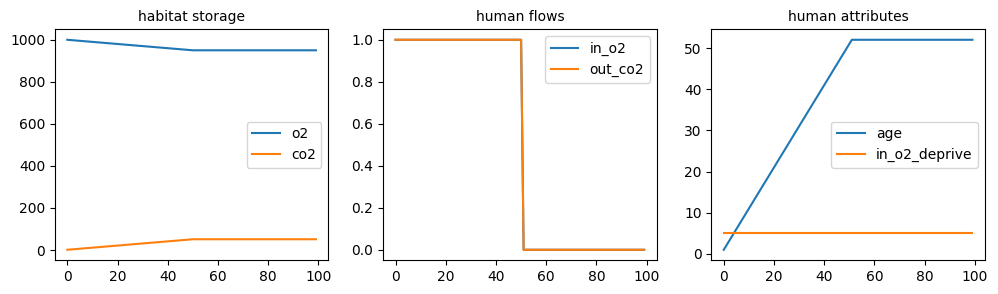

In [5]:
model = AgentModel(priorities=['inhabitants', 'structures'])
model.add_currency('o2', category='atmosphere')
model.add_currency('co2', category='atmosphere')
habitat = BaseAgent(model, 
                    'habitat', 
                    agent_class='structures', 
                    capacity={'o2': 1000, 'co2': 1000}, 
                    storage={'o2': 1000})
human = BaseAgent(model, 
                  'human', 
                  agent_class='inhabitants', 
                  thresholds={'co2': {'path': 'out_co2_ratio',
                                      'limit': '>',
                                      'value': 0.05}},
                  flows={'in': {'o2': {'value': 1, 
                                       'connections': ['habitat'],
                                       'deprive': {'value': 5}}},
                         'out': {'co2': {'value': 1,
                                         'connections': ['habitat'],
                                         'requires': ['o2']}}})
model.add_agent('habitat', habitat)
model.add_agent('human', human)
records = run_and_plot(model)
print(model.agents['human'].cause_of_death)

The amount of air a human breathes is basically proportional to their weight. To account for this, we can scale the value of each flow to the humans' weight.

1. Add a new ``property`` to humans called "mass".
2. Add a ``weighted`` parameter to the human flows with "mass" (this is "weight" as in "multiplier for a number", not "mass" - just a coincidence).
3. If we assume the average mass of a human is 80kg, we should divide the value by 80, so that the value is correct after applying the weight.

If we give our human a mass of 70kg and leave everything else the same, we'd expect them to live a bit longer.

human passed co2 threshold


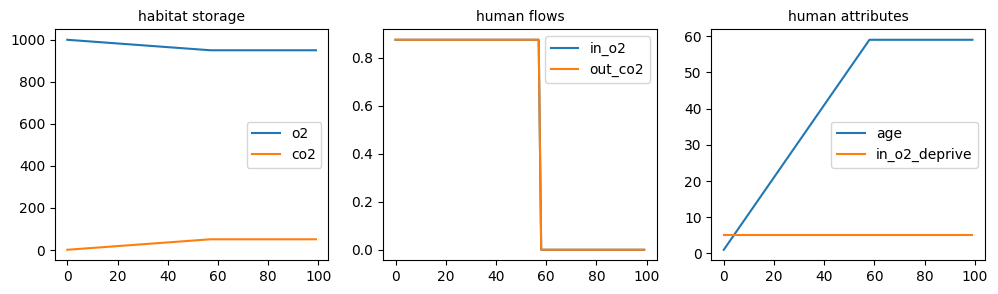

In [6]:
model = AgentModel(priorities=['inhabitants', 'structures'])
model.add_currency('o2', category='atmosphere')
model.add_currency('co2', category='atmosphere')
habitat = BaseAgent(model, 
                    'habitat', 
                    agent_class='structures', 
                    capacity={'o2': 1000, 'co2': 1000}, 
                    storage={'o2': 1000})
human = BaseAgent(model, 
                  'human', 
                  agent_class='inhabitants', 
                  thresholds={'co2': {'path': 'out_co2_ratio',
                                      'limit': '>',
                                      'value': 0.05}},
                  properties={'mass': {'value': 70}},
                  flows={'in': {'o2': {'value': 1/80, 
                                       'connections': ['habitat'],
                                       'deprive': {'value': 5},
                                       'weighted': ['mass']}},
                         'out': {'co2': {'value': 1/80,
                                         'connections': ['habitat'],
                                         'requires': ['o2'],
                                         'weighted': ['mass']}}})
model.add_agent('habitat', habitat)
model.add_agent('human', human)
records = run_and_plot(model)
print(model.agents['human'].cause_of_death)

Next, we'd expect our humans to breath less at night. An easy way to do this is by adding a ``growth`` parameter to our flows. There are several types of growth supported, but "switch" is the simples - it just flips back-and-forth between the ``min_value`` (default 0) and ``max_value`` (default 1) on a daily basis, and these are applied to the flow value as weights.

The "switch" growth function also includes a ``center`` and ``duration`` parameters, both of which are 0.5. Center is the point within a day (0-1) at which the active period is centered, and duration is the fraction of the day which is active. 

1. Add the ``growth`` parameter to o2 and co2 flows, of type "switch". 
2. We don't want o2 consumption to be 0 at night, otherwise they'll die (from o2 deprivation). Instead we can specify a ``min_value`` of 0.5.
3. Set ``center`` and ``duration`` to mimic a typical sleeping schedule of 10pm-6am: we'll move the center forward 2 hours, and increase the duration to 16 hours.

human passed co2 threshold


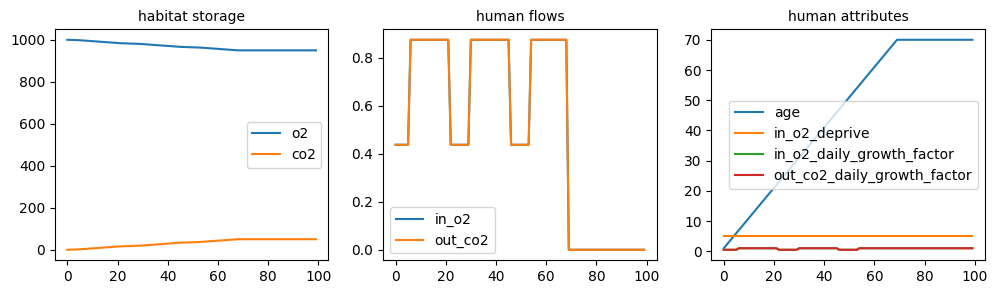

In [7]:
model = AgentModel(priorities=['inhabitants', 'structures'])
model.add_currency('o2', category='atmosphere')
model.add_currency('co2', category='atmosphere')
habitat = BaseAgent(model, 
                    'habitat', 
                    agent_class='structures', 
                    capacity={'o2': 1000, 'co2': 1000}, 
                    storage={'o2': 1000})
human = BaseAgent(model, 
                  'human', 
                  agent_class='inhabitants', 
                  thresholds={'co2': {'path': 'out_co2_ratio',
                                      'limit': '>',
                                      'value': 0.05}},
                  properties={'mass': {'value': 70}},
                  flows={'in': {'o2': {'value': 1/80, 
                                       'connections': ['habitat'],
                                       'deprive': {'value': 5},
                                       'weighted': ['mass'],
                                       'growth': {'daily': {
                                           "type": "switch", 
                                           "min_value": 0.5,
                                           "center": 14/24,
                                           "duration": 16/24}}}},
                         'out': {'co2': {'value': 1/80,
                                         'connections': ['habitat'],
                                         'requires': ['o2'],
                                         'weighted': ['mass'],
                                         'growth': {'daily': {
                                             "type": "switch", 
                                             "min_value": 0.5, 
                                             "center": 14/24,
                                             "duration": 16/24}}}}})
model.add_agent('habitat', habitat)
model.add_agent('human', human)
records = run_and_plot(model)
print(model.agents['human'].cause_of_death)

### Custom Agent Classes
We can customize things even further by creating subclasses of our ``BaseAgent``. To demonstrate this, we'll build a new agent, 'tree', to recycle the air in our habitat to keep the human alive.

1. The tree will have ``storage`` and ``capacity`` for its internal biomass
2. It will have ``flows`` of o2 and co2, but some of the co2 will be converted to internal biomass.
3. We'll make the flows ``weighted`` by the current level of internal biomass, to reflect the fact that bigger plants produce/consume more.
4. We'll add ``growth`` of type 'normal' to reflect the levels of sunlight throughout the day.

We'll setup a new helper function to return our current setup and save space, and update the run_and_plot helper function to plot our tree as well.

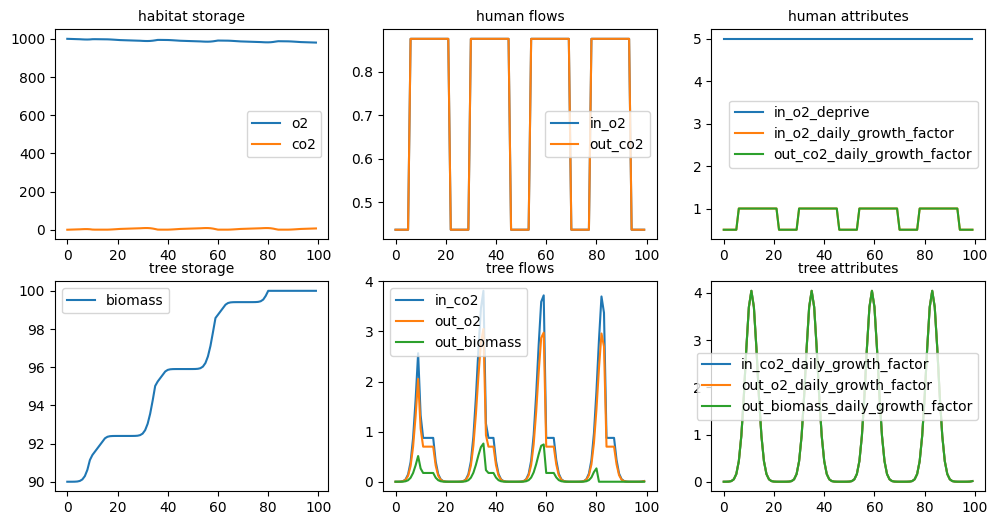

In [8]:
def get_human_model():
    model = AgentModel(priorities=['inhabitants', 'structures'])
    model.add_currency('o2', category='atmosphere')
    model.add_currency('co2', category='atmosphere')
    habitat = BaseAgent(model, 'habitat', agent_class='structures', capacity={'o2': 1000, 'co2': 1000}, storage={'o2': 1000})
    human = BaseAgent(model, 'human', agent_class='inhabitants', thresholds={'co2': {'path': 'out_co2_ratio', 'limit': '>', 'value': 0.05}}, properties={'mass': {'value': 70}}, 
                      flows={'in': {'o2': {'value': 1/80, 'connections': ['habitat'], 'deprive': {'value': 5}, 'weighted': ['mass'], 'growth': {'daily': { "type": "switch", "min_value": 0.5, "center": 14/24, "duration": 16/24}}}}, 'out': {'co2': {'value': 1/80,'connections': ['habitat'], 'requires': ['o2'], 'weighted': ['mass'], 'growth': {'daily': {"type": "switch",  "min_value": 0.5,  "center": 14/24, "duration": 16/24}}}}})
    model.add_agent('habitat', habitat)
    model.add_agent('human', human)
    return model

def run_and_plot(model):
    for i in range(100):
        model.step()
    records = model.get_records()
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    plot_agent(records, 'habitat', 'storage', ax=axs[0][0]);
    plot_agent(records, 'human', 'flows', ax=axs[0][1]);
    plot_agent(records, 'human', 'attributes', exclude=['age'], ax=axs[0][2]);
    plot_agent(records, 'tree', 'storage', ax=axs[1][0]);
    plot_agent(records, 'tree', 'flows', ax=axs[1][1]);
    plot_agent(records, 'tree', 'attributes', exclude=['age'], ax=axs[1][2]);
    return records    
    
model = get_human_model()
model.add_currency('biomass', category='nutrients')
model.priorities = ['inhabitants', 'structures', 'plants']
tree = BaseAgent(model, 'tree', agent_class='plants', 
                 capacity={'biomass': 100}, 
                 storage={'biomass': 90},
                 flows={'in': {'co2': {'value': .01,
                                       'connections': ['habitat'],
                                       'weighted': ['biomass'],
                                       'growth': {'daily': {'type': 'norm'}}}},
                        'out': {'o2': {'value': 0.008,
                                       'connections': ['habitat'],
                                       'weighted': ['biomass'],
                                       'requires': ['co2'],
                                       'growth': {'daily': {'type': 'norm'}}},
                                'biomass': {'value': 0.002,
                                            'connections': ['tree'],
                                            'weighted': ['biomass'],
                                            'requires': ['co2'],
                                            'growth': {'daily': {'type': 'norm'}}}}})
model.add_agent('tree', tree)
records = run_and_plot(model)

Now are humans are staying alive - great!

We can see that, after our tree hits 100 biomass (it's maximum storage capacity), it stops accumulating. Let's modify it so that, when it reaches maximum capacity, some of it is converted into fruit.

1. Add two new ``flows``: an inflow of biomass from the tree itself, and an outflow of ``fruit`` (we'll also add this as a currency, and add a basic ``food_storage`` agent to store it). 
2. To these flows, we'll add a new attribute ``fruiting`` to the ``weighted`` list. This will be a 0 most of the time, and 1 when we want to activate these flows.
3. We'll create a new subclass of BaseAgent called ``TreeAgent`` in order to handle the custom logic of the 'fruiting' attribute:
     1. Following the convention of other SIMOC-ABM agents, we add "fruiting" to a class property, ``default_attributes``, and insert this into the attributes kwarg in our overloaded ``__init__`` function before forwarding it to the BaseAgent "__init__" function.
     2. In the ``step`` function, we'll check if our internal biomass storage is full and, if so, set the "fruiting" attribute to 1. Remember that when overloading the ``step`` function, you should add a register loop at the beginning. In this case, ignoring it won't break anything, but it's still good practice.

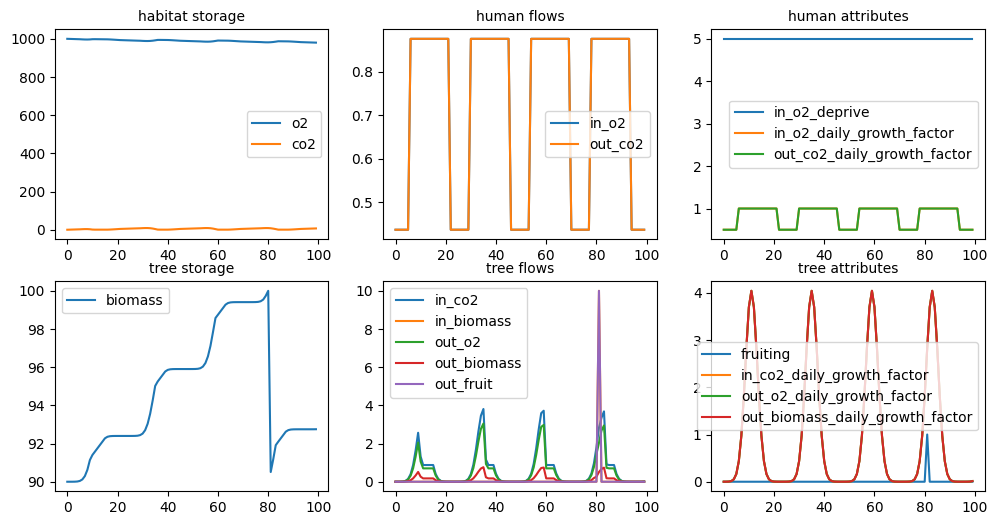

In [9]:
class TreeAgent(BaseAgent):
    default_attributes = {'fruiting': 0}
    def __init__(self, *args, attributes={}, **kwargs):
        attributes = {**attributes, **self.default_attributes}
        super().__init__(*args, attributes=attributes, **kwargs)
        
    def step(self, dT=1):
        if not self.registered:
            self.register()
        if self.storage['biomass'] == self.capacity['biomass']:
            self.attributes['fruiting'] = 1
        else:
            self.attributes['fruiting'] = 0
        super().step(dT)

model = get_human_model()
model.add_currency('biomass', category='nutrients')
model.add_currency('fruit', category='food')
model.priorities = ['inhabitants', 'structures', 'plants']
food_storage = BaseAgent(model, 'food_storage', agent_class='structures', capacity={'fruit': 100})
tree = TreeAgent(model, 'tree', agent_class='plants', 
                 capacity={'biomass': 100}, 
                 storage={'biomass': 90},
                 flows={'in': {'co2': {'value': .01,
                                       'connections': ['habitat'],
                                       'weighted': ['biomass'],
                                       'growth': {'daily': {'type': 'norm'}}},
                               'biomass': {'value': 10,
                                           'connections': ['tree'],
                                           'weighted': ['fruiting']}},
                        'out': {'o2': {'value': 0.008,
                                       'connections': ['habitat'],
                                       'weighted': ['biomass'],
                                       'requires': ['co2'],
                                       'growth': {'daily': {'type': 'norm'}}},
                                'biomass': {'value': 0.002,
                                            'connections': ['tree'],
                                            'weighted': ['biomass'],
                                            'requires': ['co2'],
                                            'growth': {'daily': {'type': 'norm'}}},
                                'fruit': {'value': 10,
                                          'connections': ['food_storage'],
                                          'weighted': ['fruiting']}}})
model.add_agent('food_storage', food_storage)
model.add_agent('tree', tree)
records = run_and_plot(model)